In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams["figure.figsize"] = (12,5)
sns.set()

from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('Metro_Interstate_Traffic_Volume.csv', index_col=['date_time'], parse_dates=['date_time'])
df

holiday    temp  rain_1h  snow_1h  clouds_all  \
date_time                                                           
2012-10-02 09:00:00    None  288.28      0.0      0.0          40   
2012-10-02 10:00:00    None  289.36      0.0      0.0          75   
2012-10-02 11:00:00    None  289.58      0.0      0.0          90   
2012-10-02 12:00:00    None  290.13      0.0      0.0          90   
2012-10-02 13:00:00    None  291.14      0.0      0.0          75   
...                     ...     ...      ...      ...         ...   
2018-09-30 19:00:00    None  283.45      0.0      0.0          75   
2018-09-30 20:00:00    None  282.76      0.0      0.0          90   
2018-09-30 21:00:00    None  282.73      0.0      0.0          90   
2018-09-30 22:00:00    None  282.09      0.0      0.0          90   
2018-09-30 23:00:00    None  282.12      0.0      0.0          90   

                     weather_main     weather_description  traffic_volume  
date_time                                                                  
2012-10-02 09:00:00        Clouds        scattered clouds            5545  
2012-10-02 10:00:00        Clouds           broken clouds            4516  
2012-10-02 11:00:00        Clouds         overcast clouds            4767  
2012-10-02 12:00:00        Clouds         overcast clouds            5026  
2012-10-02 13:00:00        Clouds           broken clouds            4918  
...                           ...                     ...             ...  
2018-09-30 19:00:00        Clouds           broken clouds            3543  
2018-09-30 20:00:00        Clouds         overcast clouds            2781  
2018-09-30 21:00:00  Thunderstorm  proximity thunderstorm            2159  
2018-09-30 22:00:00        Clouds         overcast clouds            1450  
2018-09-30 23:00:00        Clouds         overcast clouds             954  

[48204 rows x 8 columns]

# EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48204 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 3.3+ MB


In [4]:
df = df[['holiday', 'temp', 'traffic_volume']]

In [5]:
df.duplicated().any()

True

In [6]:
df.drop_duplicates(inplace=True)

### date_time

In [7]:
df.index.duplicated().any()

True

In [8]:
df = df[~df.index.duplicated()]
df.shape

(40528, 3)

In [9]:
df = df.asfreq('1H')
df.shape

(52551, 3)

### holiday

In [10]:
df.holiday.value_counts()

None                         40475
Christmas Day                    5
Columbus Day                     5
Labor Day                        5
Memorial Day                     5
Veterans Day                     5
State Fair                       5
Independence Day                 5
New Years Day                    5
Thanksgiving Day                 5
Washingtons Birthday             5
Martin Luther King Jr Day        3
Name: holiday, dtype: int64

In [11]:
df.holiday.fillna('None', inplace=True)
df.holiday = df.holiday.apply(lambda x: 0 if (x=='None' or x is None) else 1).astype('ubyte')
df.holiday.value_counts()

0    52498
1       53
Name: holiday, dtype: int64

### temp

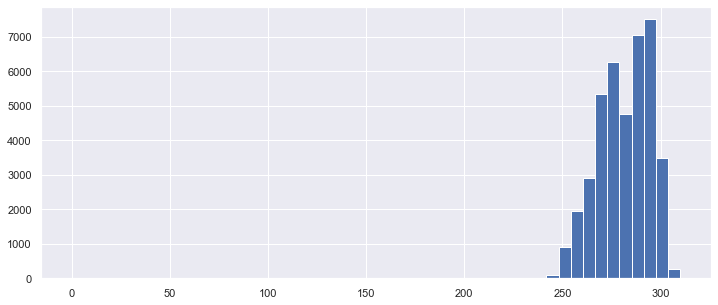

In [12]:
df.temp.hist(bins=50)

In [13]:
df.temp[lambda x: x<200].value_counts()

0.0    10
Name: temp, dtype: int64

In [14]:
df.temp[lambda x: x==0] = np.NaN

In [15]:
df.temp.isna().sum()

12033

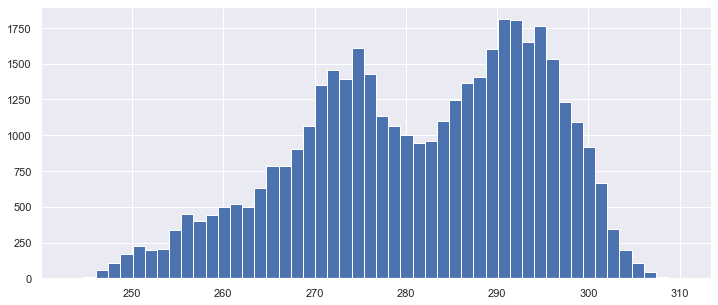

In [16]:
df.temp.hist(bins=50)

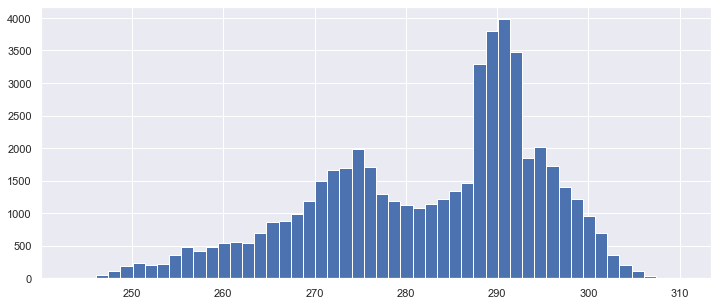

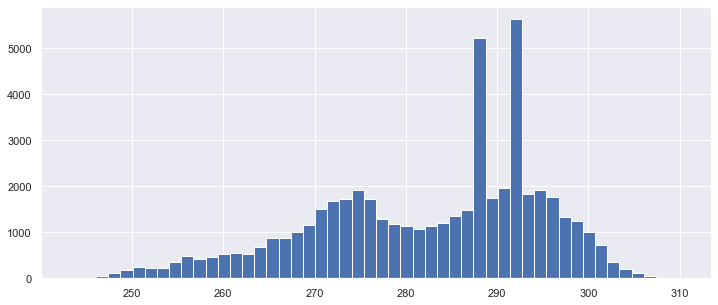

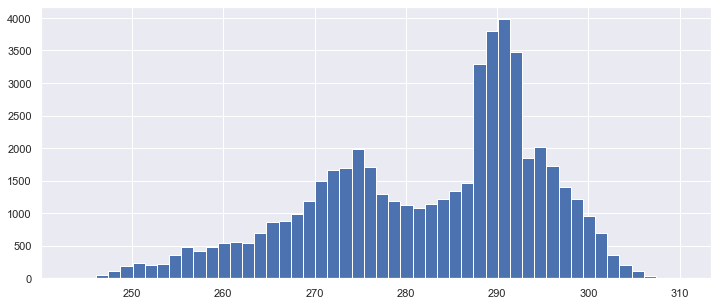

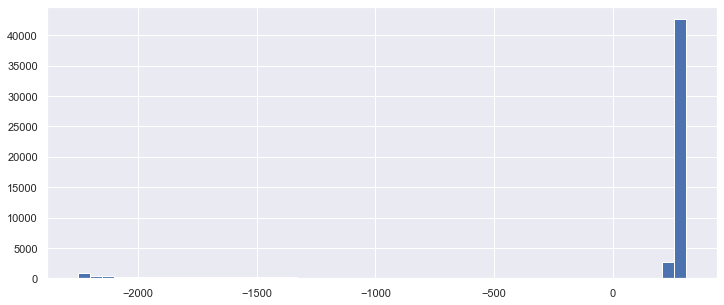

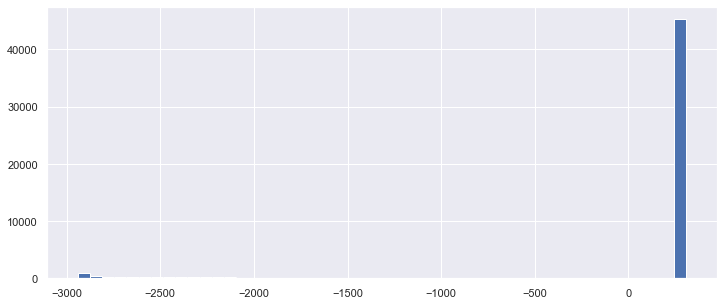

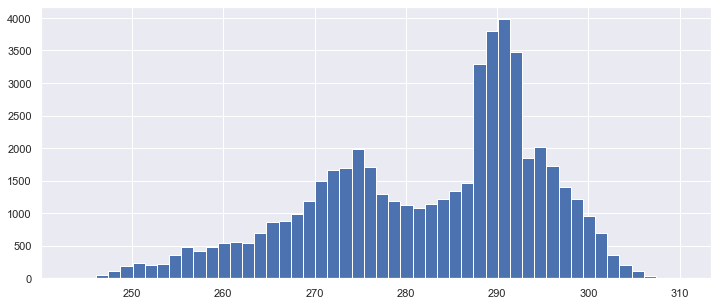

In [17]:
methods = ['linear', 'nearest', 'slinear', 'quadratic', 'cubic', 'piecewise_polynomial']
for method in methods:
    df.temp.interpolate(method=method).hist(bins=50)
    plt.show()

In [18]:
df.temp.interpolate(method='linear', inplace=True)

In [19]:
df.temp = StandardScaler().fit_transform(df.temp.values.reshape(-1, 1)).reshape(-1)

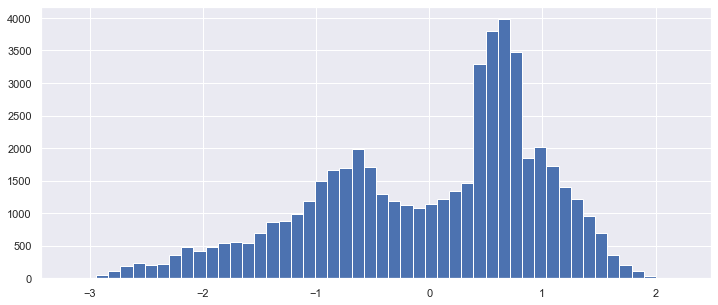

In [20]:
df.temp.hist(bins=50)

### traffic_volume

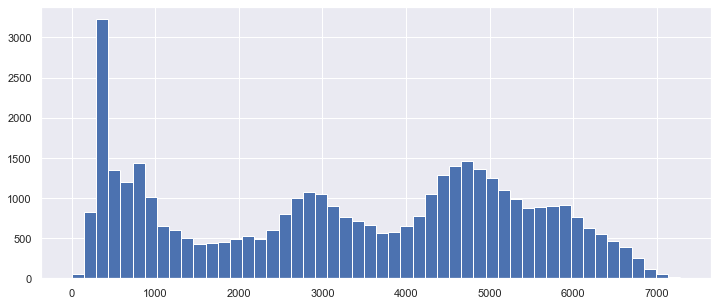

In [21]:
df.traffic_volume.hist(bins=50)

In [22]:
df.traffic_volume.isna().sum()

12023

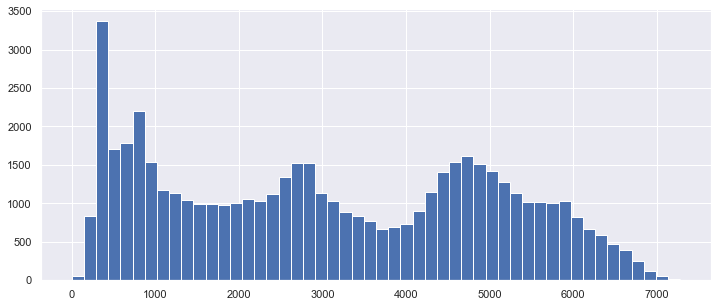

In [23]:
df.traffic_volume.interpolate().hist(bins=50)

In [24]:
df.traffic_volume.interpolate(inplace=True)

# Modeling

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [26]:
def plotMovingAverage(series, window, center=True, plot_intervals=True, scale=1.96, plot_anomalies=True):

    """
        series - dataframe with timeseries
        window - rolling window size 
        center - whether to center the window
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window, center=center).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:].fillna(0), rolling_mean[window:].fillna(0))
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.Series(index=series.index, name=series.name)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

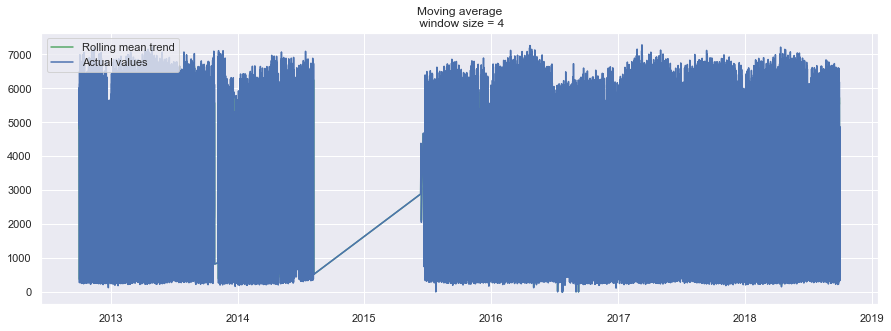

In [27]:
plotMovingAverage(df.traffic_volume, 4, plot_anomalies=False, plot_intervals=False)

In [28]:
df = df[df.index > '2016']

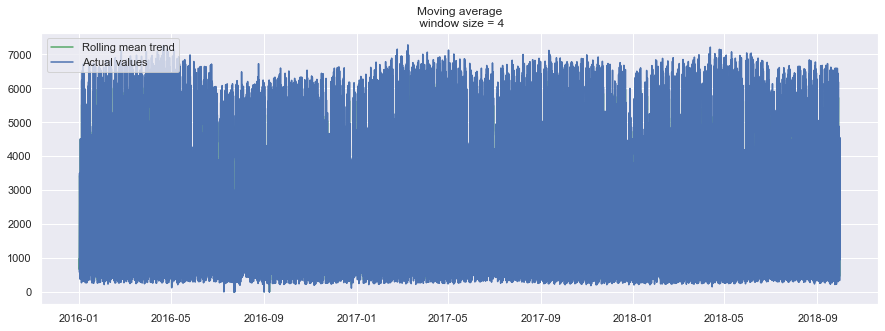

In [29]:
plotMovingAverage(df.traffic_volume, 4, plot_anomalies=False, plot_intervals=False)

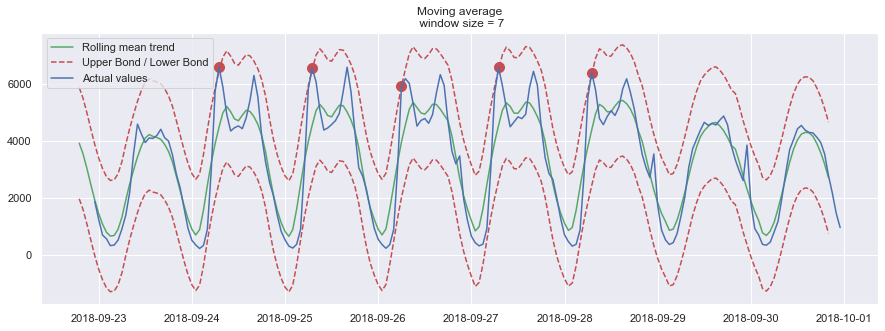

In [30]:
plotMovingAverage(df.traffic_volume[-200:], 7)

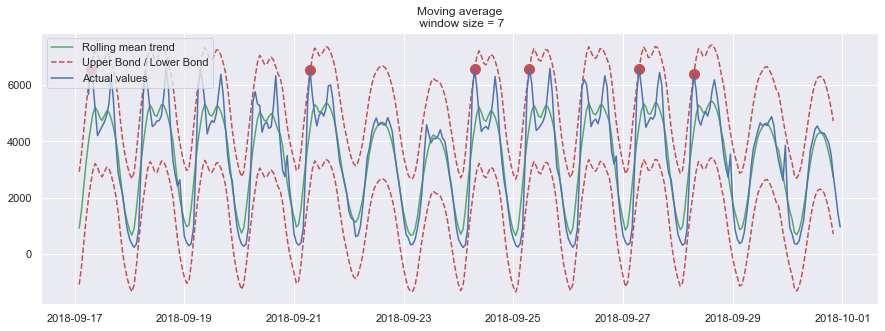

In [31]:
plotMovingAverage(df[df.index.max() - pd.offsets.Day(14) : ].traffic_volume, 7)

In [32]:
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek

In [33]:
# df_train = df[df.index.max() - pd.offsets.Week(7) + pd.offsets.Hour(1) : df.index.max() - pd.offsets.Week(1)]
# df_test = df[df.index.max() - pd.offsets.Week(1) + pd.offsets.Hour(1) : ]
df_train =  df[df.index.max() - pd.offsets.Week(9) + pd.offsets.Hour(1) : ]

## Baseline

In [34]:
baseline_week_values = df_train.groupby(["dayofweek", "hour"])["traffic_volume"].mean().values

In [35]:
def plotBaseline(series):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    n = int(len(series) / len(baseline_week_values))
    baseline_values = np.concatenate([baseline_week_values]*(n+1))
    plt.figure(figsize=(20, 10))
    plt.plot(baseline_values, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, baseline_values[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))

    m = baseline_values.mean()*0.2
    plt.vlines(len(series), ymin=baseline_values.min()-m, ymax=baseline_values.max()+m, linestyles='dashed')
    plt.axvspan(len(series)-20, len(baseline_week_values), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

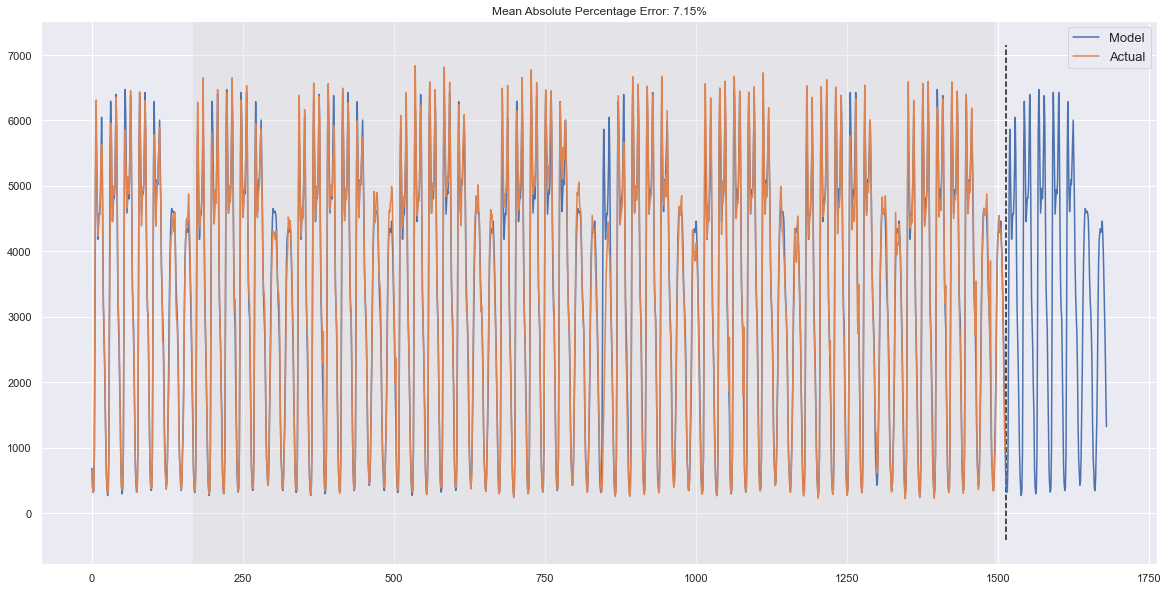

In [36]:
plotBaseline(df_train.traffic_volume)

## HoltWinters

In [37]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # print(n_seasons)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [38]:
from sklearn.model_selection import TimeSeriesSplit
from scipy.optimize import minimize

In [39]:
def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24*7):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    n_seasons = 2
    n_splits = int(len(series) / 24*7*n_seasons)

    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=2) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):
        # print(len(values[train]), len(values[test]))

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [40]:
%%time
data = df_train.traffic_volume # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(data, slen = 24*7, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 24*7, scaling_factor = 3)
model.triple_exponential_smoothing()

0.005894598493980496 0.0 0.0015090649847933624
Wall time: 1.89 s


In [41]:
def plotHoltWinters(series, plot_intervals=True, plot_anomalies=True, only_trained=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """

    # даем время модели обучиться и определяем качество теста лишь на последних 3-х неделях
    if only_trained:
        last_3_week = 24*7*3
        start = len(series)-last_3_week
        end = len(series)
    else:
        start = 0
        end = len(series)

        
    plt.figure(figsize=(20, 10))
    plt.plot(model.result[start:], label = "Model")
    plt.plot(series.values[start:end], label = "Actual")
    error = mean_absolute_percentage_error(series.values[start:end], model.result[start:end])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series[start:end]))
        anomalies[series[start:end].values<model.LowerBond[start:end]] = \
            series[start:end].values[series[start:end].values<model.LowerBond[start:end]]
        anomalies[series[start:end].values>model.UpperBond[start:end]] = \
            series[start:end].values[series[start:end].values>model.UpperBond[start:end]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond[start:end], "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond[start:end], "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result[start:end])), y1=model.UpperBond[start:end], 
                         y2=model.LowerBond[start:end], alpha=0.2, color = "grey")    
        
    plt.vlines(len(series[start:end]), ymin=min(model.LowerBond[start:end]), ymax=max(model.UpperBond[start:end]), linestyles='dashed')
    plt.axvspan(len(series[start:end])-20, len(model.result[start:end]), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

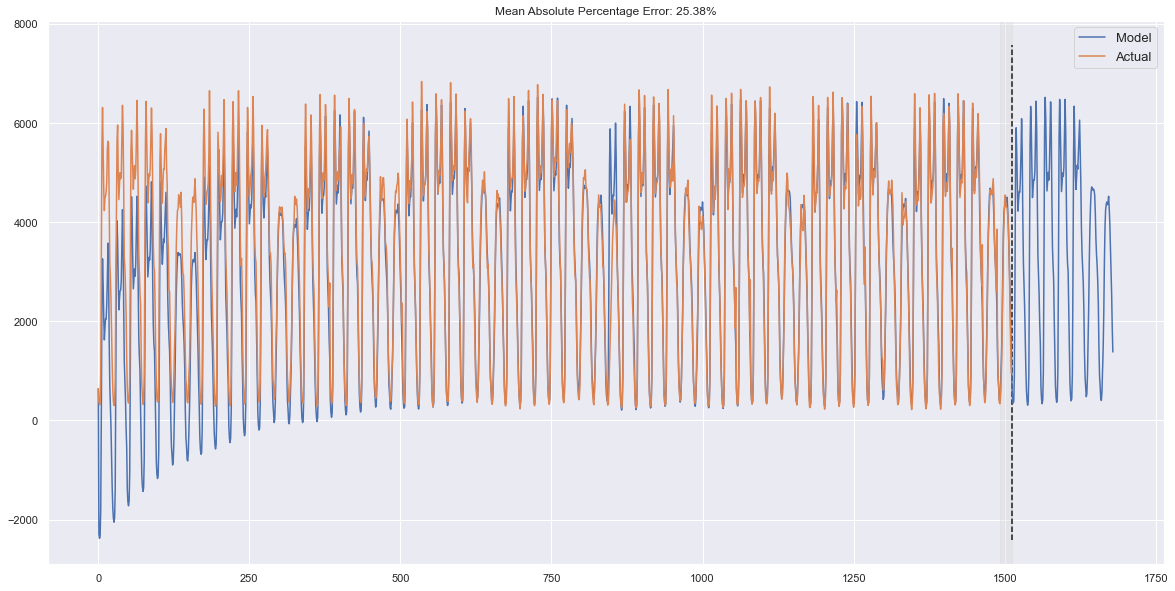

In [42]:
plotHoltWinters(df_train.traffic_volume, plot_anomalies=False, plot_intervals=False)

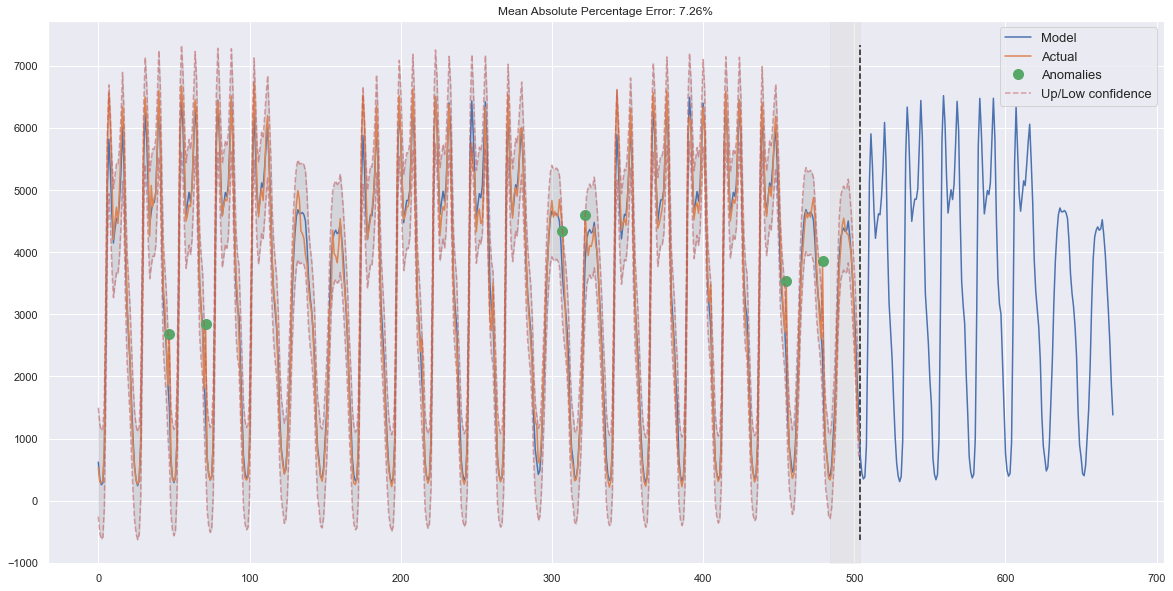

In [43]:
plotHoltWinters(df_train.traffic_volume, only_trained=True)

## Sarima

In [44]:
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [45]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, method="ols")
        plt.tight_layout()

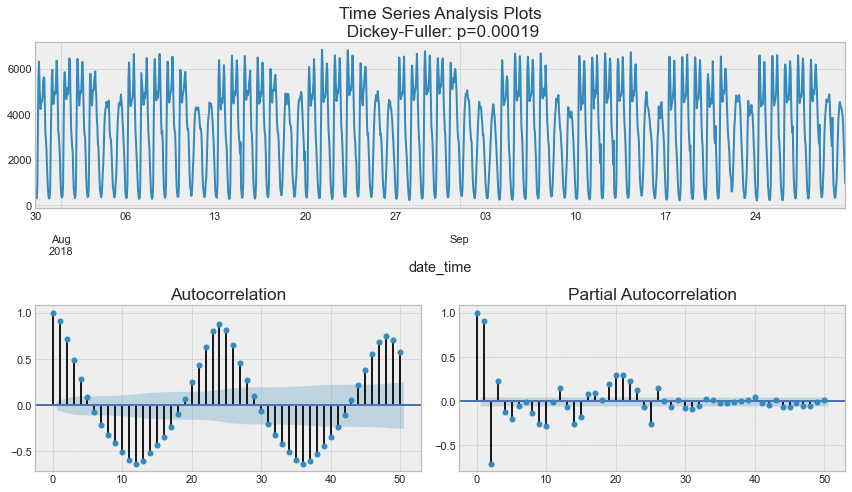

In [46]:
tsplot(df_train.traffic_volume, 50)

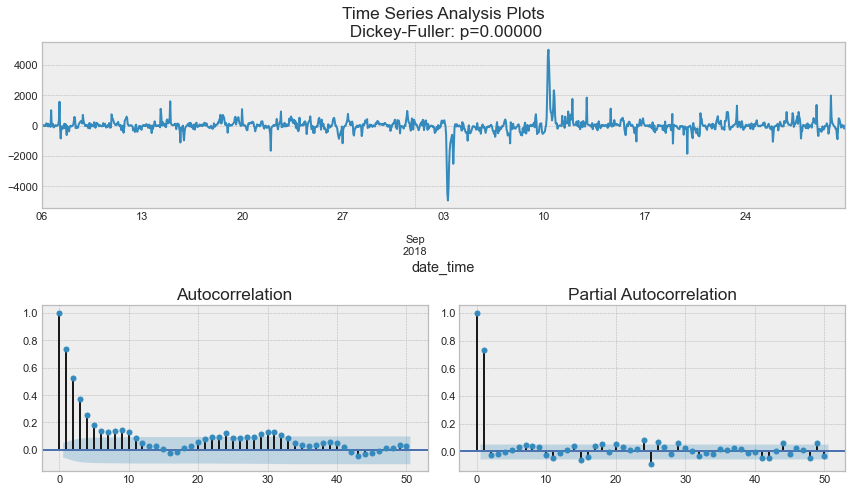

In [47]:
diffs = df_train.traffic_volume - df_train.traffic_volume.shift(24*7)
tsplot(diffs[24*7:], lags=50)

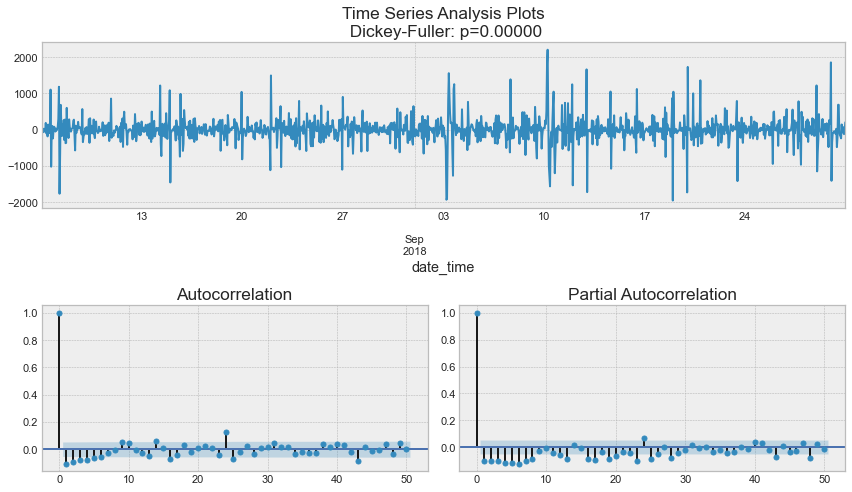

In [48]:
diff1 = diffs - diffs.shift(1)
tsplot(diff1[24*7+1:], lags=50)

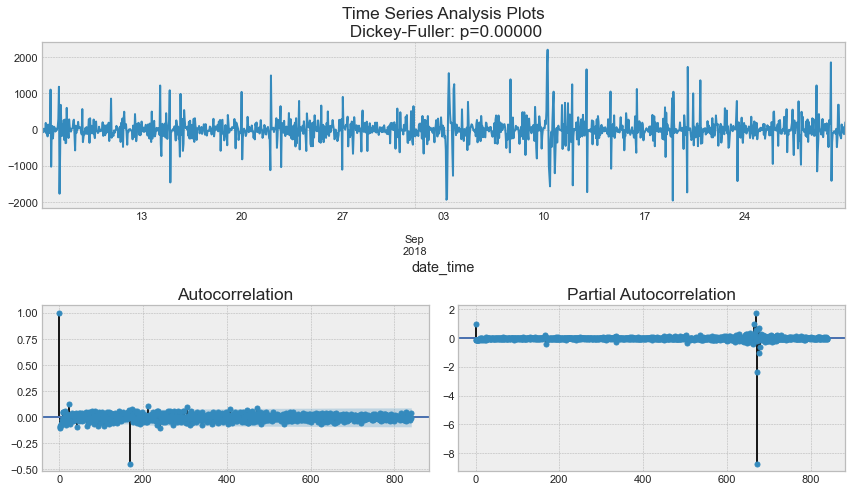

In [49]:
tsplot(diff1[24*7+1:], lags=24*7*5)

In [50]:
24*7*4

672

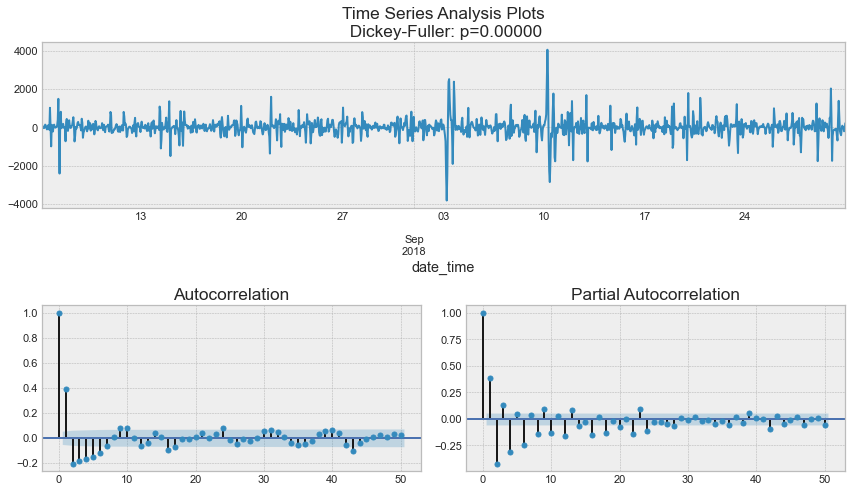

In [51]:
diff2 = diffs - diffs.shift(2)
tsplot(diff2[24*7+2:], lags=50)

In [52]:
p=1
q=1
d=1

P=1
Q=1
D=1
s=24*7

In [71]:
24*7*3

504

In [72]:
sarima_model=sm.tsa.statespace.SARIMAX(df_train.traffic_volume[:504], order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(sarima_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                      traffic_volume   No. Observations:                  504
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 168)   Log Likelihood                 677.235
Date:                             Sun, 20 Dec 2020   AIC                          -1344.470
Time:                                     12:16:04   BIC                          -1325.399
Sample:                                 07-30-2018   HQIC                         -1336.867
                                      - 08-19-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4030      0.036     11.189      0.000       0.332       0.474
ma.L1         -0.9638      

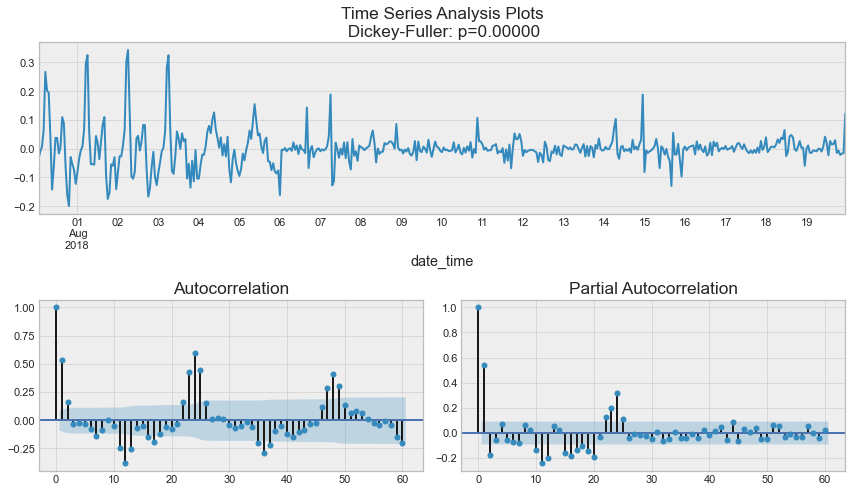

In [73]:
tsplot(sarima_model.resid[24*7+1:], lags=60)

In [47]:
def plotSARIMA(series, model, n_steps, s=24*7, d=1, plot_intervals=True, alpha=0.2):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = pd.DataFrame(series.copy())
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    # print(data.head())
    
    # forecasting on n_steps forward 
    forecast = model.get_forecast(steps=24*7)
    model_predictions = data.arima_model.append(forecast.predicted_mean)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))    
    
    plt.plot(model_predictions, color='r', label="model")
    plt.plot(data.actual, label="actual")
    
    if plot_intervals:
        intervals = forecast.conf_int(alpha=alpha)
        intervals.columns=['lower', 'upper']
        plt.plot(intervals['lower'], "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(intervals['upper'], "r--", alpha=0.5)
        plt.fill_between(x=intervals.index, y1=intervals['upper'], 
                         y2=intervals['lower'], alpha=0.2, color = "grey")    
    
    
    plt.legend()
    plt.grid(True);

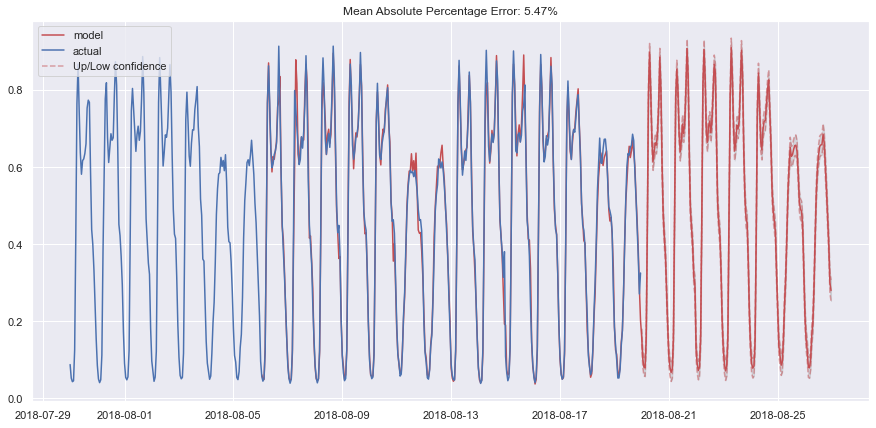

In [91]:
plotSARIMA(df_train.traffic_volume[:504], sarima_model, 50, alpha=0.5)

In [48]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(df_train.traffic_volume[:504], order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [49]:
from itertools import product  
from tqdm import tqdm_notebook

In [50]:
# setting initial values and some bounds for them
ps = [1, 6]
d=1 
qs = [1, 2]
Ps = [1, 6]
D=1 
Qs = [1]
s = 24*7 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

8

In [51]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

In [ ]:
result_table.head()

## Linear regression

In [69]:
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=3)

In [63]:
df.traffic_volume = MinMaxScaler().fit_transform(df.traffic_volume.values.reshape(-1, 1)).reshape(-1)
df_reg = df[df.index.max() - pd.offsets.Week(12) + pd.offsets.Hour(1) : ].copy()

s = 24*7
for i in range(1, 4):
    df_reg["s_lag_{}".format(i)] = df_reg.traffic_volume.shift(s*i)

for i in range(1, 5):
    df_reg["lag_{}".format(i)] = df_reg.traffic_volume.shift(i)

df_reg = df_reg[df_reg.index.max() - pd.offsets.Week(9) + pd.offsets.Hour(1) : ]

In [92]:
df_reg

holiday      temp  traffic_volume  hour  dayofweek  \
date_time                                                                 
2018-07-30 00:00:00        0  0.612837        0.087912     0          0   
2018-07-30 01:00:00        0  0.537827        0.052747     1          0   
2018-07-30 02:00:00        0  0.474915        0.043544     2          0   
2018-07-30 03:00:00        0  0.462817        0.045742     3          0   
2018-07-30 04:00:00        0  0.408777        0.125687     4          0   
...                      ...       ...             ...   ...        ...   
2018-09-30 19:00:00        0  0.072441        0.486676    19          6   
2018-09-30 20:00:00        0  0.016788        0.382005    20          6   
2018-09-30 21:00:00        0  0.014368        0.296566    21          6   
2018-09-30 22:00:00        0 -0.037252        0.199176    22          6   
2018-09-30 23:00:00        0 -0.034832        0.131044    23          6   

                      s_lag_1   s_lag_2   s_lag_3     lag_1     lag_2  \
date_time                                                               
2018-07-30 00:00:00  0.098077  0.099038  0.092857  0.168132  0.286264   
2018-07-30 01:00:00  0.055220  0.062912  0.058104  0.087912  0.168132   
2018-07-30 02:00:00  0.048626  0.040797  0.043956  0.052747  0.087912   
2018-07-30 03:00:00  0.048764  0.050549  0.047802  0.043544  0.052747   
2018-07-30 04:00:00  0.131456  0.128434  0.124038  0.045742  0.043544   
...                       ...       ...       ...       ...       ...   
2018-09-30 19:00:00  0.482967  0.467033  0.447527  0.542170  0.567582   
2018-09-30 20:00:00  0.390934  0.424725  0.378434  0.486676  0.542170   
2018-09-30 21:00:00  0.322253  0.360302  0.293956  0.382005  0.486676   
2018-09-30 22:00:00  0.224588  0.236951  0.210714  0.296566  0.382005   
2018-09-30 23:00:00  0.128297  0.149451  0.136813  0.199176  0.296566   

                        lag_3     lag_4  
date_time                                
2018-07-30 00:00:00  0.383791  0.459341  
2018-07-30 01:00:00  0.286264  0.383791  
2018-07-30 02:00:00  0.168132  0.286264  
2018-07-30 03:00:00  0.087912  0.168132  
2018-07-30 04:00:00  0.052747  0.087912  
...                       ...       ...  
2018-09-30 19:00:00  0.588324  0.590934  
2018-09-30 20:00:00  0.567582  0.588324  
2018-09-30 21:00:00  0.542170  0.567582  
2018-09-30 22:00:00  0.486676  0.542170  
2018-09-30 23:00:00  0.382005  0.486676  

[1512 rows x 12 columns]

In [65]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index-1]
    y_train = y.iloc[:test_index-1]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [66]:
y = df_reg.traffic_volume
X = df_reg.drop(['traffic_volume'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [67]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

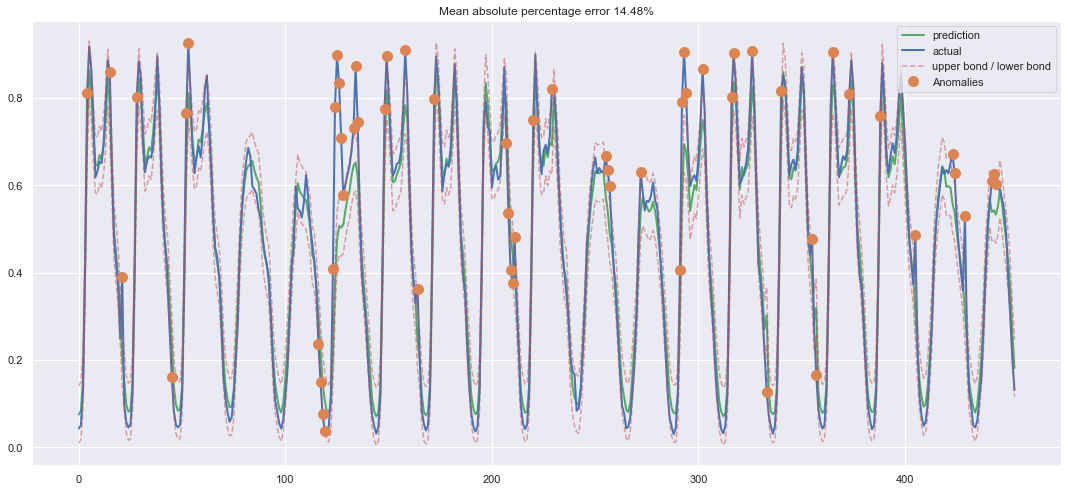

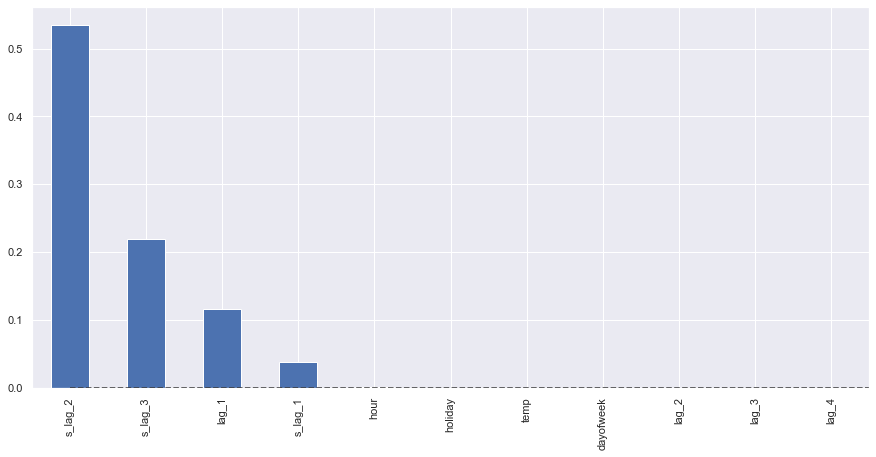

In [68]:
lasso = LassoCV(cv=tscv, eps=0.01)
lasso.fit(X_train, y_train)

plotModelResults(lasso, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

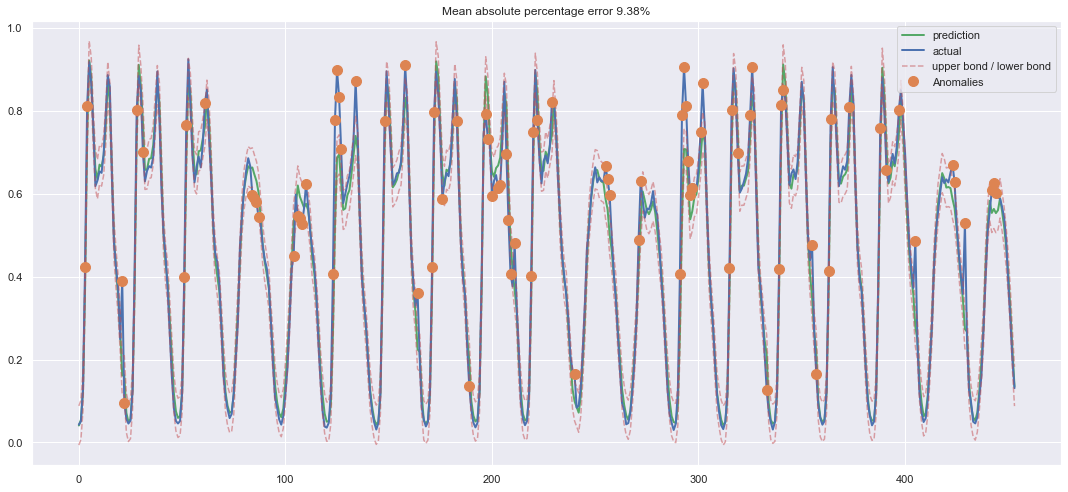

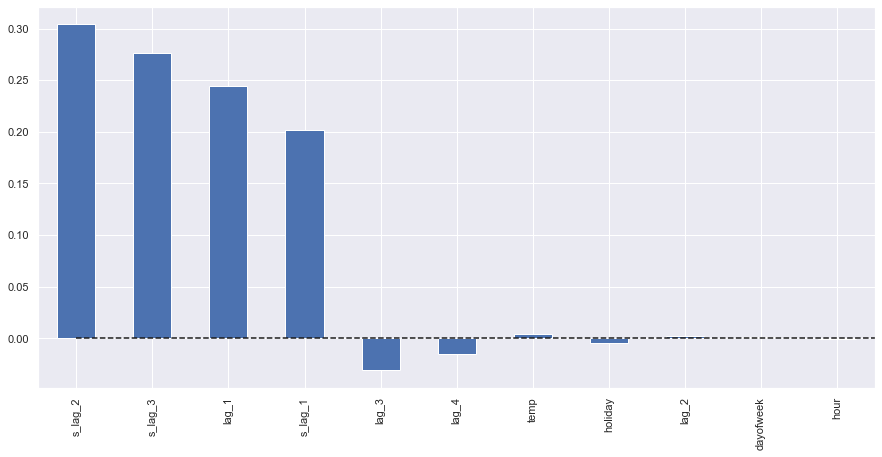

In [70]:
ridge = RidgeCV(cv=tscv, alphas=np.linspace(5, 10))
ridge.fit(X_train, y_train)

plotModelResults(ridge, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

In [95]:
df.traffic_volume = MinMaxScaler().fit_transform(df.traffic_volume.values.reshape(-1, 1)).reshape(-1)
df_reg = df[df.index.max() - pd.offsets.Week(12) + pd.offsets.Hour(1) : ].copy()

s = 24*7
df_reg["s_lag_avg_3_weeks"] = 0
for i in range(1, 4):
    df_reg["s_lag_avg_3_weeks"] += df_reg.traffic_volume.shift(s*i)
print(i)
df_reg['s_lag_avg_3_weeks'] /= 3

# for i in range(1, 5):
#     df_reg["lag_{}".format(i)] = df_reg.traffic_volume.shift(i)

df_reg = df_reg[df_reg.index.max() - pd.offsets.Week(9) + pd.offsets.Hour(1) : ]

3


In [96]:
df_reg

holiday      temp  traffic_volume  hour  dayofweek  \
date_time                                                                 
2018-07-30 00:00:00        0  0.612837        0.087912     0          0   
2018-07-30 01:00:00        0  0.537827        0.052747     1          0   
2018-07-30 02:00:00        0  0.474915        0.043544     2          0   
2018-07-30 03:00:00        0  0.462817        0.045742     3          0   
2018-07-30 04:00:00        0  0.408777        0.125687     4          0   
...                      ...       ...             ...   ...        ...   
2018-09-30 19:00:00        0  0.072441        0.486676    19          6   
2018-09-30 20:00:00        0  0.016788        0.382005    20          6   
2018-09-30 21:00:00        0  0.014368        0.296566    21          6   
2018-09-30 22:00:00        0 -0.037252        0.199176    22          6   
2018-09-30 23:00:00        0 -0.034832        0.131044    23          6   

                     s_lag_avg_3_weeks  
date_time                               
2018-07-30 00:00:00           0.096658  
2018-07-30 01:00:00           0.058745  
2018-07-30 02:00:00           0.044460  
2018-07-30 03:00:00           0.049038  
2018-07-30 04:00:00           0.127976  
...                                ...  
2018-09-30 19:00:00           0.465842  
2018-09-30 20:00:00           0.398031  
2018-09-30 21:00:00           0.325504  
2018-09-30 22:00:00           0.224084  
2018-09-30 23:00:00           0.138187  

[1512 rows x 6 columns]

In [97]:
y = df_reg.traffic_volume
X = df_reg.drop(['traffic_volume'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

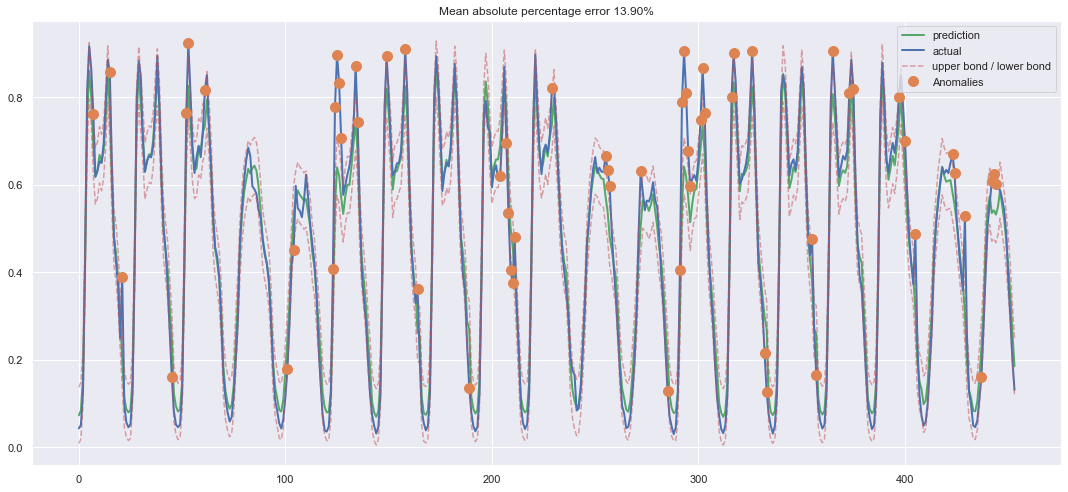

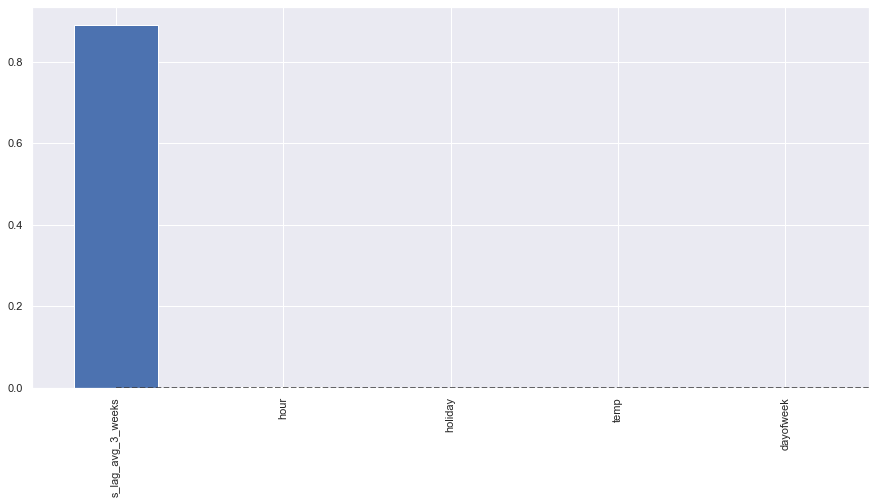

In [98]:
lasso = LassoCV(cv=tscv, eps=0.01)
lasso.fit(X_train, y_train)

plotModelResults(lasso, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

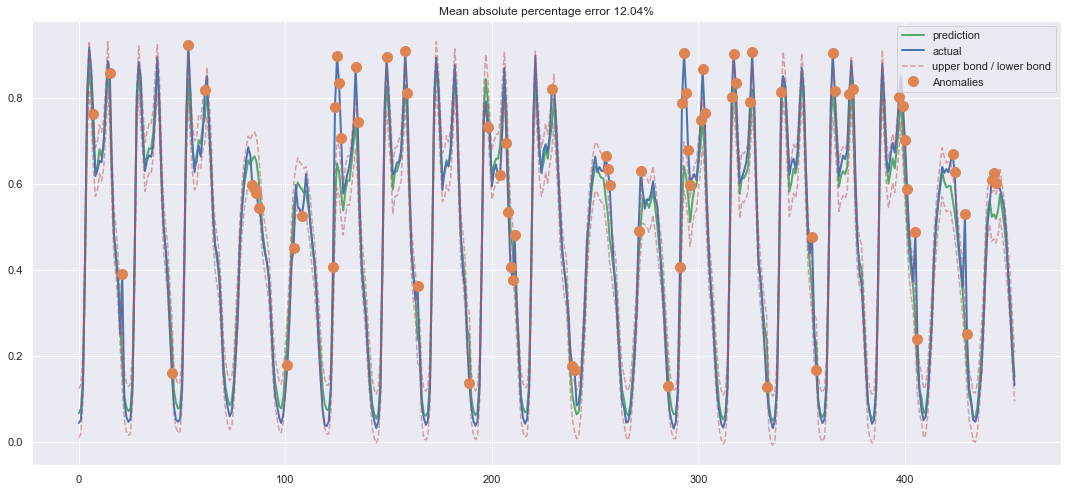

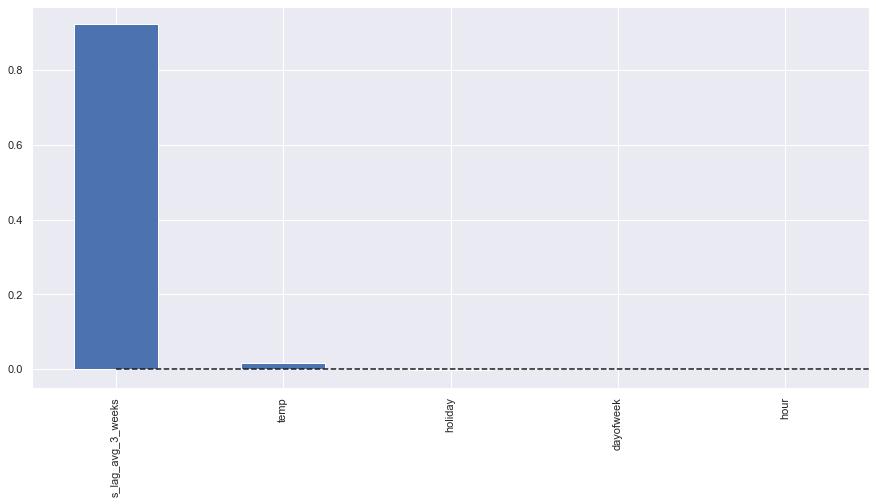

In [99]:
ridge = RidgeCV(cv=tscv, alphas=np.linspace(5, 10))
ridge.fit(X_train, y_train)

plotModelResults(ridge, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)